In [1]:
from fastai.vision.all import *
from fastai.data.external import untar_data, URLs

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [13]:
images = []
for i in range(0, 10):
  images.append([tensor(Image.open(o)) for o in (path/'training'/str(i)).ls().sorted()])

In [43]:
valid_images = []
for i in range(0, 10):
  valid_images.append([tensor(Image.open(o)) for o in (path/'testing'/str(i)).ls().sorted()])

In [26]:
images[0][0].shape

torch.Size([28, 28])

In [45]:
valid_images[0][0].shape

torch.Size([28, 28])

<Axes: >

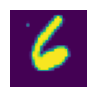

In [19]:
show_image(images[6][0])

<Axes: >

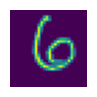

In [46]:
show_image(valid_images[6][0])

In [23]:
[len(x) for x in images]

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [47]:
[len(x) for x in valid_images]

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]

In [24]:
stacked_images = [torch.stack(x).float()/255 for x in images]

In [48]:
stacked_valid_images = [torch.stack(x).float()/255 for x in valid_images]

In [28]:
stacked_images[7].shape

torch.Size([6265, 28, 28])

In [31]:
train_x = torch.cat(stacked_images).view(-1, 28*28)

In [32]:
train_x.shape

torch.Size([60000, 784])

In [35]:
results = []
for i in range(0, 10):
  results += [i] * len(images[i])

len(results)

60000

In [51]:
valid_results = []
for i in range(0, 10):
  valid_results += [i] * len(valid_images[i])

len(valid_results)

10000

In [38]:
train_y = tensor(results).unsqueeze(1)

In [39]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [93]:
train_y.squeeze().shape

torch.Size([60000])

In [42]:
dset = list(zip(train_x, train_y))
x,y = dset[13000]
x.shape, y

(torch.Size([784]), tensor([2]))

In [52]:
valid_x = torch.cat(stacked_valid_images).view(-1, 28*28)
valid_y =  tensor(valid_results).unsqueeze(1)

In [53]:
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [54]:
valid_dset = list(zip(valid_x, valid_y))

In [55]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

In [77]:
weights = init_params((28 * 28, 10))
bias = init_params(10)

In [79]:
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

In [84]:
def linear1(xb): return xb@weights + bias

preds = linear1(train_x)
preds.shape

torch.Size([60000, 10])

In [81]:
loss_fn = nn.CrossEntropyLoss()


In [94]:
loss = loss_fn(preds, train_y.squeeze())

In [95]:
loss

tensor(17.4915, grad_fn=<NllLossBackward0>)

In [144]:
def mnist_loss(predictions, targets):
  return loss_fn(predictions, targets.squeeze())

In [97]:
weights = init_params(((28 * 28), 10))
bias = init_params(10)

In [98]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [99]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [100]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [102]:
preds = linear1(batch)

In [104]:
loss = mnist_loss(preds, train_y[:4].squeeze())
loss

tensor(0.1048, grad_fn=<NllLossBackward0>)

In [105]:
loss.backward()

In [106]:
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 10]),
 tensor(-5.1318e-10),
 tensor([-8.9473e-02,  2.0751e-07,  2.3304e-07,  1.4743e-07,  1.2066e-04,
          1.2091e-02,  1.3534e-08,  3.0806e-04,  7.6953e-02,  2.7351e-13]))

In [107]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [109]:
calc_grad(batch, train_y[:4].squeeze(), linear1)

In [135]:
def train_epoch(model, lr, params):
  for xb,yb in dl:
    calc_grad(xb, yb.squeeze(), model)
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()

In [131]:
preds.shape

torch.Size([4, 10])

In [128]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = xb.argmax(dim=1) == yb
  return correct.float().mean()

In [132]:
batch_accuracy(preds, train_y)

tensor(0.0987)

In [123]:
x = torch.randn(2, 3)
print(x)

x.argmax(dim=1)

tensor([[-0.7630,  1.8518, -0.8048],
        [ 1.6010,  0.6717,  0.8892]])


tensor([1, 0])

In [118]:
tensor([2]) == tensor([23])

tensor([False])

In [130]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [133]:
validate_epoch(linear1)

0.1576

In [136]:
lr = 1
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.1869

In [138]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.4735 0.4748 0.4765 0.4779 0.4795 0.4804 0.4812 0.4818 0.4824 0.4833 0.485 0.4849 0.4853 0.4857 0.4863 0.4867 0.4869 0.4872 0.4883 0.4887 

In [148]:
class MLearner:
  def __init__(self, dls, model, opt_func, loss_func, metrics):
    self.dls = dls
    self.model = model
    self.opt_func = opt_func
    self.loss_func = loss_func
    self.metrics = metrics

  def fit(self, epoch, lr):
    for i in range(epoch):
      for xb,yb in self.dls[0]:
        preds = self.model(xb)
        loss = self.loss_func(preds, yb)
        loss.backward()

        self.model.weight.data -= self.model.weight.grad * lr
        self.model.weight.grad.zero_()

        self.model.bias.data -= self.model.bias.grad * lr
        self.model.bias.grad.zero_()

      accs = [self.metrics(self.model(xb), yb) for xb,yb in self.dls[1]]
      print(round(torch.stack(accs).mean().item(), 4))


In [149]:
learner = MLearner([dl, valid_dl], nn.Linear(28*28, 10), opt_func="SGD", loss_func = mnist_loss, metrics=batch_accuracy)

In [154]:
learner.fit(100, 20)

0.4753
0.4728
0.4735
0.4752
0.4768
0.4694
0.4814
0.4766
0.4772
0.4781
0.4758
0.478
0.4767
0.461
0.4908
0.4787
0.4774
0.4708
0.4905
0.4749
0.4847
0.4771
0.4857
0.4779
0.4827
0.4834
0.4772
0.4896
0.4749
0.4811
0.4795
0.4878
0.4751
0.4841
0.4664
0.4915
0.4879
0.4743
0.4897
0.4748
0.4914
0.4796
0.489
0.4737
0.4941
0.4773
0.4875
0.4763
0.489
0.4819
0.4771
0.4877
0.474
0.4875
0.4835
0.4809
0.4833
0.4763
0.4885
0.48
0.4934
0.4795
0.4904
0.4731
0.4907
0.4887
0.4795
0.4865
0.4817
0.488
0.4878
0.4877
0.476
0.485
0.4906
0.4755
0.4945
0.4881
0.4862
0.4908
0.4851
0.4908
0.4749
0.4949
0.4891
0.4898
0.4744
0.4925
0.4793
0.4884
0.4829
0.4889
0.4838
0.4947
0.4796
0.4922
0.4836
0.4928
0.4833
0.496
